In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import yfinance as yf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, f1_score
from sklearn.preprocessing import StandardScaler

In [2]:
xmr_difficulty = pd.read_csv('./data_phase2/XMR_difficulty.csv')
xmr_hash = pd.read_csv('./data_phase2/XMR_hash.csv')

In [3]:
xmr = yf.Ticker("XMR-USD XMR-BTC XMR-EUR XMR-CNY")
df = yf.download(tickers = "XMR-USD",
                     period = "max",
                     interval = "1d")
df.reset_index(inplace=True)
# df.drop(columns=['Adj Close'], inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [4]:
### Add Target vector as a separate column to dataframe for later reference
### This is Target Vector
df['Price_Direction'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [5]:
df['HighLow'] = df['High'] - df['Low']
df['OpenClose'] = df['Open'] - df['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume,Price_Direction,HighLow,OpenClose
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,0,11.185997,-8.248001
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1,19.907997,15.758003
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,1,23.228004,-13.865997
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,0,23.057007,-4.259003
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,0,15.606003,5.558006
...,...,...,...,...,...,...,...,...,...,...
2161,2023-10-10,153.790405,154.468155,152.097107,152.215652,152.215652,54504811,1,2.371048,1.574753
2162,2023-10-11,152.220093,153.929443,150.970428,153.842102,153.842102,61162383,0,2.959015,-1.622009
2163,2023-10-12,153.852783,154.344238,151.021347,152.341812,152.341812,65445853,1,3.322891,1.510971
2164,2023-10-13,152.339523,154.368774,151.051971,153.590515,153.590515,51282283,0,3.316803,-1.250992


In [6]:
### Calculate RSI Indicator

### First Calculate the difference of each day's price with prior day
change = df["Close"].diff()
change = change.dropna()

### Create two copies of the Closing price Series
change_up = change.copy()
change_down = change.copy()

change_up[change_up<0] = 0
change_down[change_down>0] = 0

### Verify no mistakes were made
change.equals(change_up+change_down)

### Calculate the rolling average of average up and average down
window_size = 14
avg_up = change_up.rolling(window_size).mean()
avg_down = change_down.rolling(window_size).mean().abs()

### Calculate RSI using its formula
rsi = 100 * avg_up / (avg_up + avg_down)

### Add RSI index to dataframe
df['RSI'] = rsi
rsi.isna().value_counts()

Close
False    2152
True       13
Name: count, dtype: int64

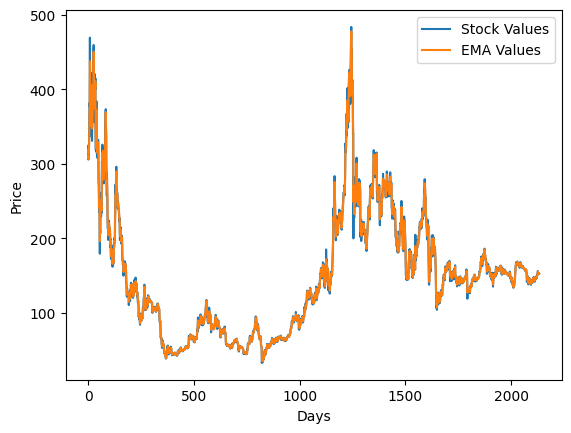

In [16]:
### Calculate EMA Indicator

ema = df['Close'].ewm(com=0.5).mean()
### Add EMA index to dataframe
df['EMA'] = ema

### Comparison plot b/w stock values & EMA
plt.plot(df['Close'], label="Stock Values")
plt.plot(ema, label="EMA Values")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show() 
### We can see that EMA index predicts out stock value (closing price) pretty good.

In [8]:
### Calculate SMA Indicator

### Get the window of series of observations of specified window size 
window_size = 14
windows = df['Close'].rolling(window_size) 
  
### Create a series of simple moving averages of each window 
sma = windows.mean() 

### Add SMA index to dataframe
df['SMA'] = sma

In [9]:
### Calculate MACD Indicator

### Get the 26-day EMA of the closing price
k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
### Get the 12-day EMA of the closing price
d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()

### Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

### Get the 9-Day EMA of the MACD for the Trigger line
### Slow MACD
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

### Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

### Add MACD new values to the dataframe
df['macd'] = macd
# df_xmr_usd['macd_h'] = macd_h
df['macd_s'] = macd_s

In [10]:
### Calculate Bollinger Band Indicator

# df = df_xmr_usd[['Close']]

# sma = df.rolling(window=20).mean().dropna()
# rstd = df.rolling(window=20).std().dropna()

# upper_band = sma + 2 * rstd
# lower_band = sma - 2 * rstd

# upper_band = upper_band.rename(columns={'Close': 'upper_band'})
# lower_band = lower_band.rename(columns={'Close': 'lower_band'})
# df_xmr_usd = df_xmr_usd.join(upper_band).join(lower_band)
# df_xmr_usd.head(50)

In [11]:
### Drop NaN values because of the nature of RSI, EMA, SMA and MACD calculations >>> This is normal.
df.dropna(inplace=True)
### Reset Index
df.reset_index(drop=True, inplace=True)

### Assign features and target 
y = df['Price_Direction']
X = df.drop(columns=['Price_Direction', 'Date'])

In [12]:
### Use Grid Search for optimal K

### Feature scaling
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

### Split data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_neighbors': range(1, 21)  
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 21)}, scoring='f1')

In [13]:
### Create and Train KNeighborsClassifier model 
best_n_neighbors = grid_search.best_params_['n_neighbors']
print(f"Best n_neighbors(or k) by grid search is : {best_n_neighbors}\n")
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

Best n_neighbors(or k) by grid search is : 17



KNeighborsClassifier(n_neighbors=17)

In [14]:
y_predict = knn.predict(X_test)

In [15]:
f1 = f1_score(y_test, y_predict)
print(f"F1 score : {f1 * 100}")

F1 score : 51.14345114345114
